In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta

In [4]:
#Loading saved data
d = pickle.load(open('04-09-2020.p','rb'))
X = d['X']
Y = d['Y']

In [5]:
#Removing one location's data from X
long, lat = 32.5757, 0.322320

In [6]:
#getting the indices of the rows with that locations' data
location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))

In [7]:
#creating X dataset
Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
Xset.shape

(7335, 3)

In [8]:
location_indices

(array([ 939,  940,  941,  942,  943,  944,  945,  946,  947,  948,  949,
         950,  951,  952,  953,  954,  955,  956,  957,  958,  959,  960,
         961,  962,  963,  964,  965,  966,  967,  968,  969,  970,  971,
         972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,
         983,  984,  985,  986,  987,  988,  989,  990,  991,  992,  993,
         994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003, 1004,
        1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015,
        1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026,
        1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037,
        1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048,
        1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059,
        1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070,
        1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081,
        1082, 1083, 1084, 1085, 1086, 

In [9]:
#creating Y dataset
Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
Yset.shape

(7335, 1)

In [10]:
#Removing Nans
keep = ~np.isnan(Yset[:,0])
Yset = Yset[keep,:]
Xset = Xset[keep,:]

In [11]:
#Creating training dataset
Xtraining = Xset[::10,:]
Ytraining = Yset[::10,:]
Xtraining.shape, Ytraining.shape

((734, 3), (734, 1))

In [12]:
#data of deleted location
Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
Xtest.shape, Ytest.shape

((160, 3), (160, 1))

In [13]:
#defining the kernel
k = gpflow.kernels.RBF(lengthscales=[0.01, 0.01, 1.]) + gpflow.kernels.Bias()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
╘═════════════════════════════╧═

In [14]:
#training the model
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[0].lengthscales, False) 
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │

In [15]:
#model optimization
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 752.252815102796  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.01 0.01 1.  ]  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus   

In [16]:
#Making predictions
mean, var = m.predict_f(Xtest)

In [17]:
Ytest

array([[ 31.62      ],
       [ 31.64522727],
       [ 38.4295122 ],
       [ 48.63595238],
       [ 61.58162791],
       [ 61.39930233],
       [ 50.27465116],
       [ 35.59953488],
       [ 38.67813953],
       [ 46.29674419],
       [ 56.83487805],
       [ 46.91465116],
       [ 46.3872093 ],
       [ 40.77261905],
       [ 39.68121951],
       [ 43.28627907],
       [ 41.78659091],
       [ 32.69594595],
       [ 22.67227273],
       [ 21.93431818],
       [ 21.94658537],
       [ 26.12613636],
       [ 19.11954545],
       [ 17.57613636],
       [ 26.0627907 ],
       [ 34.38904762],
       [ 44.47075   ],
       [ 40.55095238],
       [ 39.29119048],
       [ 37.58418605],
       [ 42.03209302],
       [ 46.12488372],
       [ 44.08767442],
       [ 37.30975   ],
       [ 41.48952381],
       [ 34.77214286],
       [ 35.24139535],
       [ 27.84186047],
       [ 37.20232558],
       [ 43.0447619 ],
       [ 30.6725    ],
       [ 19.35512195],
       [ 19.24113636],
       [ 15

In [18]:
#CalculatiNG RMSE
rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
rmse

18.095076622579064

In [19]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

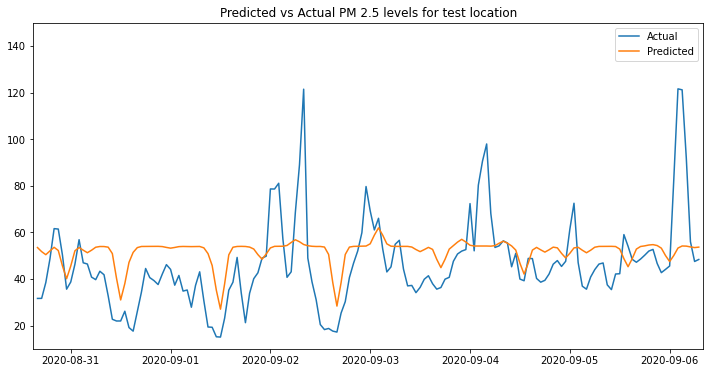

<Figure size 432x288 with 0 Axes>

In [22]:
#Plotting results
plt.figure(figsize=(12,6))
plt.title('Predicted vs Actual PM 2.5 levels for test location')
plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
plt.ylim(10,150)
plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
plt.plot(f2(Xtest[:, 2]), mean.numpy(), label='Predicted')
plt.legend(loc='best')
plt.show()
plt.savefig('predicted_vs_actual.png')

In [28]:
def cross_validation(long, lat, i):
    '''
    Performs cross validation by removing a specific location's data from the dataset
    '''
    
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    try:
        #Removing location's data from dataset
        Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
        Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
    
        #Removing Nans
        keep = ~np.isnan(Yset[:,0])
        Xset = Xset[keep,:]
        Yset = Yset[keep,:]
    
       #Creating training dataset
        Xtraining = Xset[::10,:]
        Ytraining = Yset[::10,:]
    
        #creating test dataset
        Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
        Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
        #training the model
        m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
        set_trainable(m.kernel.kernels[0].lengthscales, False) 
    
        #model optimization
        opt = gpflow.optimizers.Scipy()

        def objective_closure():
             return - m.log_marginal_likelihood()

        opt_logs = opt.minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))
    
        #Making predictions
        mean, var = m.predict_f(Xtest)
    
        #CalculatiNG RMSE and appending to list
        rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
        rmse_list.append({'latitude':lat, 'longitude':long, 'rmse':rmse})
    
        #f = lambda time: Timestamp.fromtimestamp(time*3600)
        #f2 = np.vectorize(f)
    
        #Plotting actual vs predicted
        #plt.figure(figsize=(12,6))
        #plt.title('Location '+str(i))
        #plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
        #plt.ylim(10,150)
        #plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
        #plt.plot(f2(Xtest[:, 2]), mean.numpy(), label='Predicted')
        #plt.legend(loc='best')
        #plt.show()
        #plt.savefig('cross_validation/location_'+str(i)+'.png')
    except:
        pass

In [29]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]

In [30]:
rmse_list = []
for i in range(len(longs)):
    cross_validation(longs[i], lats[i],i)

In [31]:
rmse_list

[{'latitude': 0.391478, 'longitude': 32.62583, 'rmse': 17.448407743156956},
 {'latitude': 0.2689, 'longitude': 32.588, 'rmse': 38.571512617782055},
 {'latitude': 0.322108, 'longitude': 32.576, 'rmse': 18.073745959506915},
 {'latitude': 0.286595, 'longitude': 32.506107, 'rmse': 28.35545043116123},
 {'latitude': 0.3655, 'longitude': 32.6468, 'rmse': 19.92373538855437},
 {'latitude': 0.3577745, 'longitude': 32.5842442, 'rmse': 24.85755749391855},
 {'latitude': 0.341674, 'longitude': 32.635306, 'rmse': 54.90647087806462},
 {'latitude': 0.34646, 'longitude': 32.70328, 'rmse': 17.686958272444393},
 {'latitude': 0.32232, 'longitude': 32.5757, 'rmse': 18.094819903601614},
 {'latitude': 0.325346, 'longitude': 32.632288, 'rmse': 19.909553767395963},
 {'latitude': 0.360209, 'longitude': 32.610756, 'rmse': 18.3671524491091},
 {'latitude': 0.3759, 'longitude': 32.528, 'rmse': 45.7086992485543},
 {'latitude': 0.363, 'longitude': 32.529, 'rmse': 31.812324713887847},
 {'latitude': 0.307, 'longitude': 